In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from dcegm.solve.solve import solve_retirement_model
%matplotlib inline
%load_ext autoreload

%autoreload 2

In [2]:
# Number of periods (fist period is t=1) 
num_periods = 25

# Number of grid points over assets
num_grid = 500

# Maximum level of assets
mmax = 50

# Number of quadrature points used in calculation of expectations
n_quad_points = 5

# Number of simulations
nsims = 50

# Interval of the initial wealth
init = [10, 30]

# Interest rate
r = 0.05

# Discount factor
beta = 0.95

# Standard deviation of log-normally distributed income shocks
sigma = 0.00

# Disutility of work
cost_work = 0.35

# CRRA coefficient (log utility if ==1)
theta = 1.95

# Careful with the coefficients here -- original code had the polynomial
# Coded as a + b * x - c * x**2 ... (note the crazy minus)
coeffs_age_poly = np.array([0.75, 0.04, -0.0002])

# Consumption floor (safety net in retirement)
cfloor = 0.001

# Scale of the EV taste shocks 
lambda_ = 2.2204e-16

In [3]:
def Value_period_1(beta, R, y, delta, M,retired=False):
    
    v_retire = np.log(M/(1+beta)) + beta * np.log(R*(M - (M/(1+beta))))

    if retired is False:
        v_work = np.log((M + y/R)/ (1+ beta)) + beta * np.log(R*(M - ((M + y/R)/ (1+ beta))) + y) - delta
        x = np.maximum(v_work, v_retire)

        return x
    else:
        return v_retire

    
def Value_period_2(beta, R, y, delta, M, c):
    v_work_value_1 = Value_period_1(beta, R, y, delta, M-c + y) 
    
    v_work = np.log(c) + beta * v_work_value_1 - delta
    
    return v_work
    


In [4]:
beta = 0.98
R = 1
y = 20
delta = 1
c = np.arange(10, 30, 0.0001)

Values = {}
for M in [28, 29, 30.5626, 31, 32]:
    Values[M] = []
    for element in c:
        Values[M] += [Value_period_2(0.98, 1, 20, 1, M, element)]

Values[1] = [7.306] * len(Values[28])


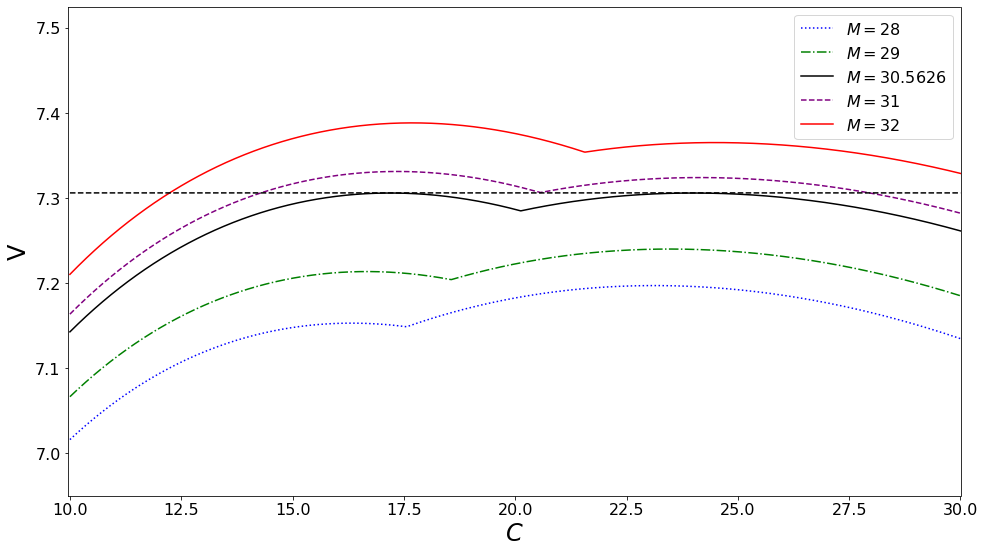

In [5]:
ax = plt.figure(figsize=[16,9]).add_subplot(111)
ax.set_ylabel("V", fontsize=24)
ax.set_xlabel("$C$", fontsize=24)
ax.set_ylim(6.95, 7.525)
ax.set_xlim(9.95, 30)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.plot(c, Values[28], linestyle=':', color='blue',label= "$M=28$")
plt.plot(c, Values[29], linestyle='-.', color='green', label= "$M=29$")
plt.plot(c, Values[30.5626], color='black',label= "$M =  30.5626$")
plt.plot(c, Values[31], linestyle='--', color='purple', label= "$M=31$")
plt.plot(c, Values[32], color='red', label= "$M=32$")
plt.plot(c, Values[1], color='black',linestyle='--')

plt.legend(loc='upper right', prop={"size": 16}, frameon=True)

In [6]:
def value_function_work(beta, R, y, delta, M, c):
    v_work = np.log(c) + beta * np.log(R*(M - c) + y) - delta
    return v_work
def value_function_retire(beta, R, y, delta, M, c):
    v_retire = np.log(c) + beta * np.log(R*(M - c)) 
    return v_retire

beta = 0.98
R = 1
y = 20
delta = 1
c = np.arange(1, 38, 0.0001)
M = 38

aux_dict = {'retire': [], 'work': []}

for i in c:
    aux_dict['work'] += [value_function_work(beta, R, y, delta, M, i)]
    aux_dict['retire'] += [value_function_retire(beta, R, y, delta, M, i)]
    


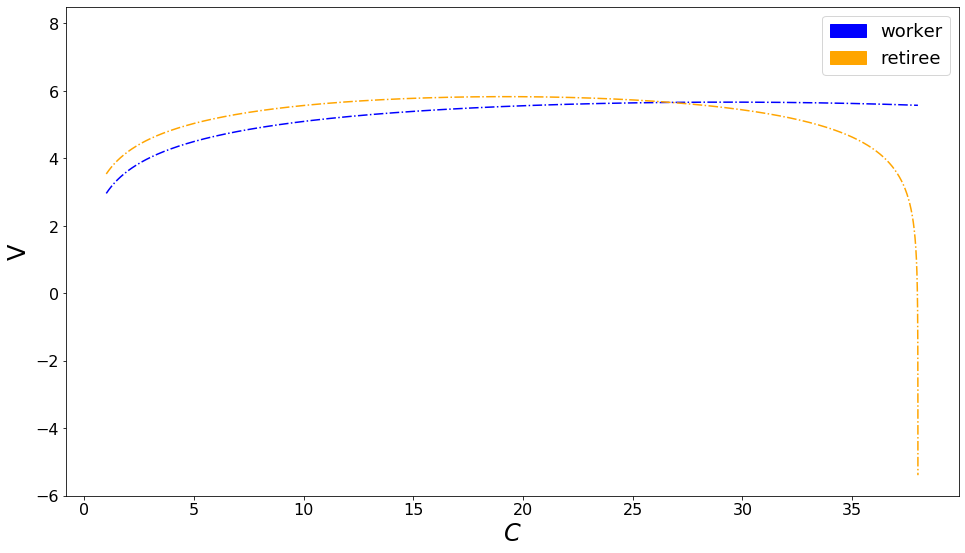

In [7]:
ax = plt.figure(figsize=[16,9]).add_subplot(111)
ax.set_ylabel("V", fontsize=24)
ax.set_xlabel("$C$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-6.00, 8.5)

plt.plot(c, aux_dict['work'], linestyle='-.', color='blue', label='Work')
plt.plot(c, aux_dict['retire'], linestyle='-.', color='orange', label = 'retire')
blue_patch = mpatches.Patch(color="blue", label="worker")
orange_patch = mpatches.Patch(color="orange", label="retiree")
ax.legend(handles=[blue_patch, orange_patch], loc='upper right', prop={"size": 18}, frameon=True)


In [8]:
value, policy = solve_retirement_model(
    num_grid,
    n_quad_points,
    r, coeffs_age_poly,
    theta,
    cost_work,
    beta,
    lambda_,
    sigma,
    mmax,
    num_periods)

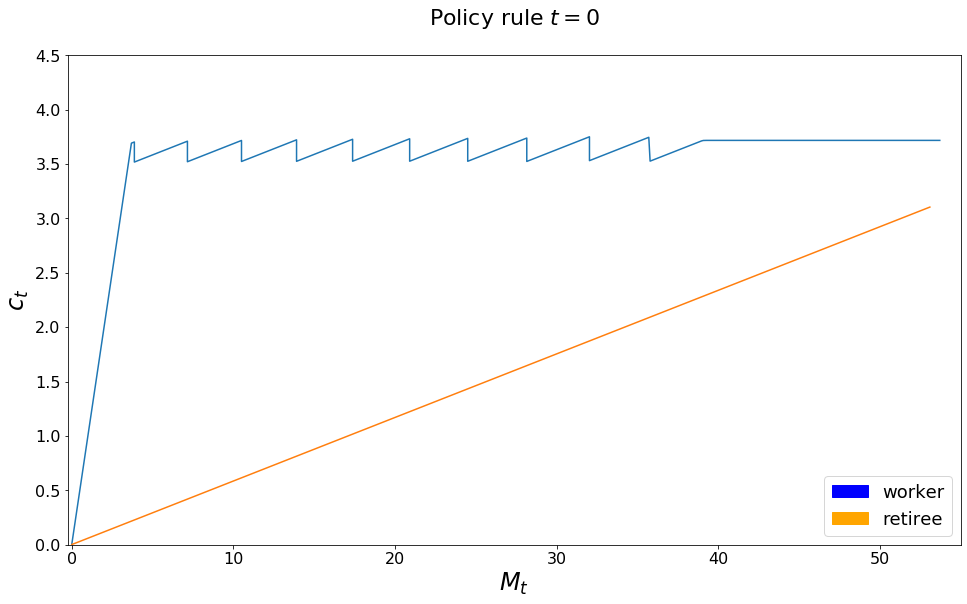

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel(r"$M_t$", fontsize=24)
ax.set_ylabel(r"$c_t$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(0.0, 4.5)
ax.set_xlim(-0.25, 55)

blue_patch = mpatches.Patch(color="blue", label="worker")
orange_patch = mpatches.Patch(color="orange", label="retiree")
ax.legend(handles=[blue_patch, orange_patch], loc='lower right', prop={"size": 18}, frameon=True)
plt.title('Policy rule $t=0$',  loc='center', fontdict={'fontsize':22})
ax.title.set_position([.5, 1.05])

plt.plot(policy[0][1].T[0], policy[0][1].T[1])
plt.plot(policy[0][0].T[0], policy[0][0].T[1])


In [10]:
values = []
policies = []
for lambda_ in np.arange(2.2204e-16, 0.1, 0.05):
    value, policy = solve_retirement_model(
    num_grid,
    n_quad_points,
    r, coeffs_age_poly,
    theta,
    cost_work,
    beta,
    lambda_,
    sigma,
    mmax,
    num_periods)
    values += [value]
    policies += [policy]

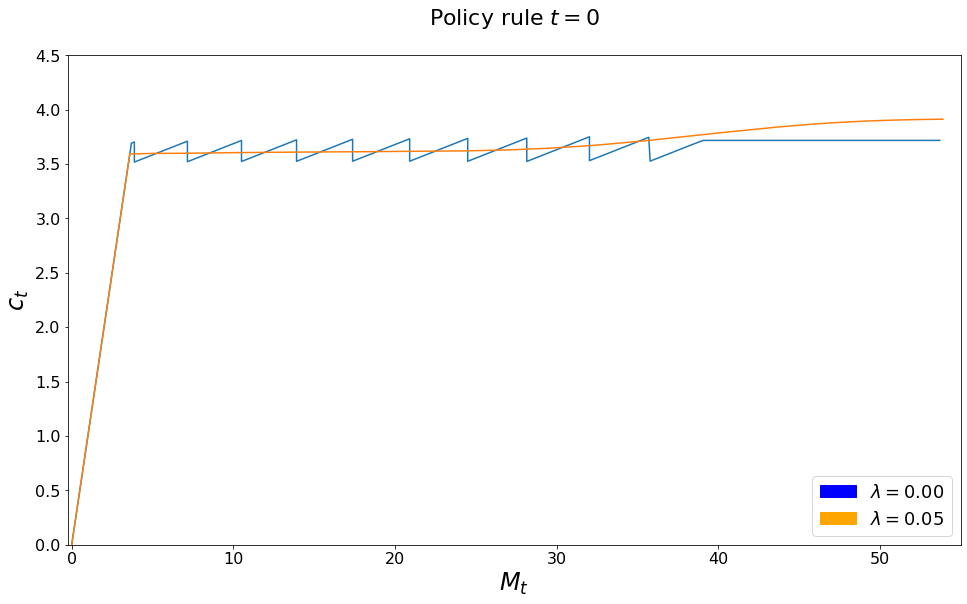

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel(r"$M_t$", fontsize=24)
ax.set_ylabel(r"$c_t$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(0.0, 4.5)
ax.set_xlim(-0.25, 55)

blue_patch = mpatches.Patch(color="blue", label="$\lambda = 0.00$")
orange_patch = mpatches.Patch(color="orange", label="$\lambda = 0.05$")
ax.legend(handles=[blue_patch, orange_patch], loc='lower right', prop={"size": 18}, frameon=True)
plt.title('Policy rule $t=0$',  loc='center', fontdict={'fontsize':22})
ax.title.set_position([.5, 1.05])

for i in range(len(policies)):
    plt.plot(policies[i][0][1].T[0], policies[i][0][1].T[1])


In [12]:
lambda_ = 2.2204e-16
from dcegm.solve.egm_step import egm_step
import scipy.stats as scps
from scipy.special.orthogonal import ps_roots

from dcegm.solve.solve_auxiliary import create_container

quadstnorm = scps.norm.ppf(ps_roots(n_quad_points)[0])
quadw = ps_roots(n_quad_points)[1]
# define savingsgrid
savingsgrid = np.linspace(0, mmax, num_grid)
# Set up list containers
policy, value = create_container(
    num_grid, num_periods, savingsgrid, theta, cost_work
)
# state = 0 retirement
# state = 1 worker
for period in range(num_periods - 2, -1, -1):
    # TODO: For state = 0, no need to solve egm.
    for state in [1, 0]:
        value, policy, ev = egm_step(
            value,
            policy,
            state,
            savingsgrid,
            quadstnorm,
            period,
            num_periods,
            num_grid,
            cfloor,
            n_quad_points,
            r,
            coeffs_age_poly,
            theta,
            cost_work,
            beta,
            lambda_,
            sigma,
            quadw,
        )


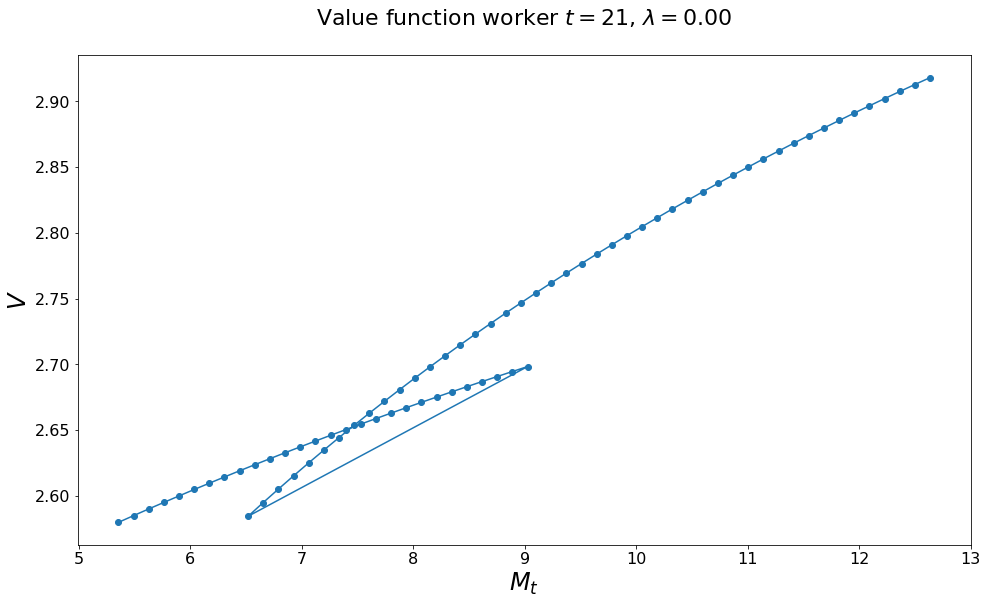

In [13]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel(r"$M_t$", fontsize=24)
ax.set_ylabel(r"$V$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.title('Value function worker $t=21$, $\lambda = 0.00$',  loc='center', fontdict={'fontsize':22})
ax.title.set_position([.5, 1.05])

plt.plot( value[21][1].T[0][1:75], value[21][1].T[1][1:75], marker='o')



In [14]:
from dcegm.solve.egm_step import egm_step
import scipy.stats as scps
from scipy.special.orthogonal import ps_roots

from dcegm.solve.solve_auxiliary import create_container
lambda_ = 0.01

quadstnorm = scps.norm.ppf(ps_roots(n_quad_points)[0])
quadw = ps_roots(n_quad_points)[1]
# define savingsgrid
savingsgrid = np.linspace(0, mmax, num_grid)
# Set up list containers
policy, value = create_container(
    num_grid, num_periods, savingsgrid, theta, cost_work
)
# state = 0 retirement
# state = 1 worker
for period in range(num_periods - 2, -1, -1):
    # TODO: For state = 0, no need to solve egm.
    for state in [1, 0]:
        value, policy, ev = egm_step(
            value,
            policy,
            state,
            savingsgrid,
            quadstnorm,
            period,
            num_periods,
            num_grid,
            cfloor,
            n_quad_points,
            r,
            coeffs_age_poly,
            theta,
            cost_work,
            beta,
            lambda_,
            sigma,
            quadw,
        )


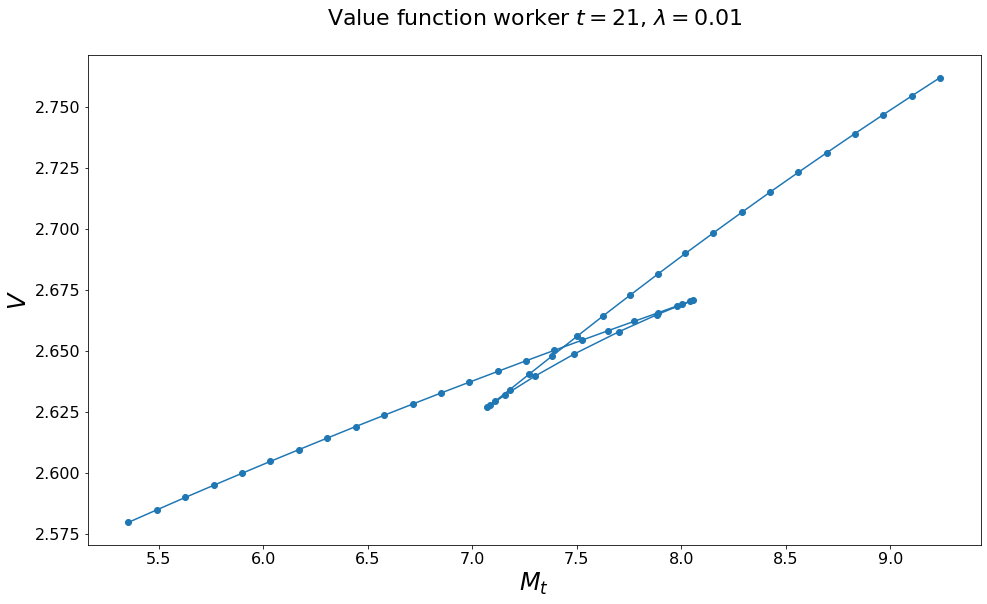

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel(r"$M_t$", fontsize=24)
ax.set_ylabel(r"$V$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.title('Value function worker $t=21$, $\lambda = 0.01$',  loc='center', fontdict={'fontsize':22})
ax.title.set_position([.5, 1.05])

plt.plot( value[21][1].T[0][1:50], value[21][1].T[1][1:50], marker='o')



In [16]:
value_, policy_ = solve_retirement_model(
num_grid,
n_quad_points,
r, coeffs_age_poly,
theta,
cost_work,
beta,
lambda_,
sigma,
mmax,
num_periods)


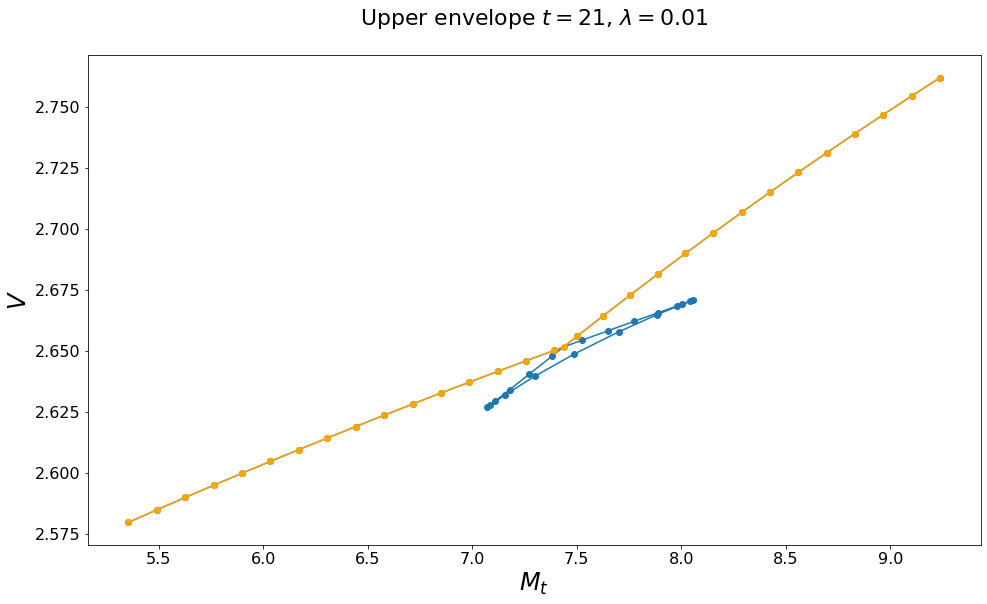

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_xlabel(r"$M_t$", fontsize=24)
ax.set_ylabel(r"$V$", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.title('Upper envelope $t=21$, $\lambda = 0.01$',  loc='center', fontdict={'fontsize':22})
ax.title.set_position([.5, 1.05])

plt.plot( value[21][1].T[0][1:50], value[21][1].T[1][1:50], marker='o')
plt.plot( value_[21][1].T[0][1:32], value_[21][1].T[1][1:32], marker='o', color="orange")

